### 🧠 What is Query Planning and Decomposition?
Query Planning and Decomposition is a technique where a complex user query is broken down into simpler sub-questions or tasks, allowing a system (like a RAG agent) to:

- Understand the question more deeply
- Retrieve more precise and complete information
- Execute step-by-step reasoning

It's like reverse-engineering a question into manageable steps before answering.

🧠 What's New in This Version?
- ✅ Add a Query Planner Node
- ✅ Break complex user queries into sub-questions
- ✅ Retrieve docs per sub-question
- ✅ Combine all retrieved contexts
- ✅ Generate a final consolidated answer

In [1]:
import os
from typing import List
from pydantic import BaseModel
from langchain_huggingface import HuggingFaceEmbeddings
from langchain.schema import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import FAISS
from langchain_community.document_loaders import TextLoader,WebBaseLoader
from langgraph.graph import StateGraph, END

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [2]:
from langchain_groq import ChatGroq
from dotenv import load_dotenv
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

llm=ChatGroq(model="openai/gpt-oss-120b")

In [4]:
# ----------------------------
# 1. Load and Embed Documents
# ----------------------------
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2024-04-12-diffusion-video/"
]
docs = []
for url in urls:
    docs.extend(WebBaseLoader(url).load())

splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
chunks = splitter.split_documents(docs)

embeddings=HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
vectorstore = FAISS.from_documents(chunks, embeddings)
retriever = vectorstore.as_retriever()


c:\Users\ChitreshKaushik\Documents\RAG_UseCases\RAG\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# ----------------------------
# 2. State Schema
# ----------------------------
class RAGState(BaseModel):
    question: str
    sub_questions: List[str] = []
    retrieved_docs: List[Document] = []
    answer: str = ""

In [7]:
# ----------------------------
# 3. Nodes
# ----------------------------

## a. Query Planner: splits input question
def plan_query(state: RAGState) -> RAGState:
   
    prompt = f"""
Break the following complex question into 2-3 sub-questions:

Question: {state.question}

Sub-questions:
"""
    result = llm.invoke(prompt)
    sub_questions = [line.strip("- ").strip() for line in result.content.strip().split("\n") if line.strip()]
    return RAGState(question=state.question, sub_questions=sub_questions)

## b. Retrieve documents for each sub-question
def retrieve_for_each(state: RAGState) -> RAGState:
    all_docs = []
    for sub in state.sub_questions:
        docs = retriever.invoke(sub)
        all_docs.extend(docs)
    return RAGState(question=state.question, sub_questions=state.sub_questions, retrieved_docs=all_docs)

## c. Generate final answer
def generate_final_answer(state: RAGState) -> RAGState:
    context = "\n\n".join([doc.page_content for doc in state.retrieved_docs])
    prompt = f"""
Use the context below to answer the question.

Context:
{context}

Question: {state.question}
"""
    
    answer = llm.invoke(prompt).content
    return RAGState(question=state.question, sub_questions=state.sub_questions, retrieved_docs=state.retrieved_docs, answer=answer)


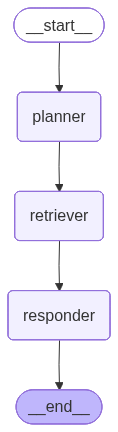

In [8]:
# ----------------------------
# 4. Build LangGraph
# ----------------------------
builder = StateGraph(RAGState)

builder.add_node("planner", plan_query)
builder.add_node("retriever", retrieve_for_each)
builder.add_node("responder", generate_final_answer)

builder.set_entry_point("planner")
builder.add_edge("planner", "retriever")
builder.add_edge("retriever", "responder")
builder.add_edge("responder", END)

graph = builder.compile()
graph

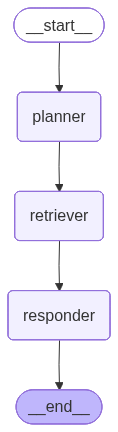

In [9]:
graph

In [10]:
# ----------------------------
# 5. Run the pipeline
# ----------------------------
if __name__ == "__main__":
    user_query = "Explain how agent loops work and what are the challenges in diffusion video generation?"
    initial_state = RAGState(question=user_query)
    final_state = graph.invoke(initial_state)
    print(final_state)

    print("\n🔍 Sub-questions:")
    for q in final_state['sub_questions']:
        print("-", q)

    print("\n✅ Final Answer:\n", final_state['answer'])

{'question': 'Explain how agent loops work and what are the challenges in diffusion video generation?', 'sub_questions': ['**Possible sub‑questions**', '1. **What is an agent loop, and what are its main components (perception, reasoning, action, feedback) that enable an autonomous agent to operate?**', '2. **How does the feedback mechanism within an agent loop work in practice (e.g., updating internal state, handling errors, and adapting behavior over time)?**', '3. **What are the primary technical and practical challenges when applying diffusion models to video generation (e.g., computational cost, temporal consistency, conditioning, and scalability)?**'], 'retrieved_docs': [Document(id='85bdce98-43eb-4a44-8c2a-80cbb68f459f', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts dem

In [2]:
s = 'You are an AI assistant tasked with going through customer care email threads and outputting **True** if the thread requires no response, and **False** if the thread requires manual processing. \nYou will receive up to the latest four conversations from an email thread.\n\n**Context:**\n- You will be provided with email data which contains a thread of communication. The email thread will only contain up to four latest emails.\n- The email data is in reverse chronological order (most recent messages at top).\n- Any email could contain inquiries that need response or action.\n- An inquiry is considered resolved if it has been properly addressed in a later message.\n- The email data could also contain attachments containing information.\n\n**Task:**\n- Analyze the email data and decide if the thread requires a response.\n- Output strictly **True** if the classification is "No Response Required".\n- Output strictly **False** if the classification is "Manual Processing".\n- Do not output anything other than **True** or **False**.\n\n**Email Thread to Analyze (variable: email_data):**\n{email_data}\n\n**Criteria for Output:**\n\n1. **True (No Response Required)**\n1.1 Purely informational emails: If the latest email in the thread is purely informational, a thank-you note, categorize it as \'No Response Required\'.   Ensure there are no unresolved queries in the email thread.\n1.1.1. If the latest email is solely a thank-you note (e.g., "Thank you", "Thanks", "Thanks for the update"), or acknowledgement or is an email forward without requesting action from the customer service team and there are no new questions or requests for further action in that message, categorize the thread as \'No Response Required\'. Ignore earlier parts of the thread unless the latest email reopens or adds to a previous query.\n1.2. Responses already provided: If the latest email is a response to earlier inquiries provided by Medtronic\'s team, categorize it as \'No Response Required\'.\n1.3. Latest email warrants no follow-up: When dealing with email chains in the email data, if the latest email requires no action, categorize the entire thread as \'No Response Required\'.\n\n\n2. **False (Manual Processing)**\n- Any case that does not strictly fall under the "True" criteria.\n\n**Examples:**\n\nTrue Example (No Response Required)\nEmail data:\n------------------------------------\nOlÃ¡ Rose,\n\nObrigado, confirmo a primeira entrega. Retornarei apÃ³s o restante da entrega.\n\nAtenciosamente,\nAmelia Souza\nCliente SaÃºde\n\nAssunto: Re: Consulta sobre Pedido\nDe: rafael@medtronic.com\nPara: amelia@clientesaude.com\nCc: rose@medtronic.com, atencaoaocliente@medtronic.com\nData de chegada: 25 de outubro de 2023, 10:30\n\nPrezada Amelia,\n\nObrigado pelo seu contato. Em relaÃ§Ã£o ao seu pedido #98765, 17 unidades do item CFN-001 serÃ£o entregues no dia 26 de outubro de 2023. As 13 unidades restantes do item CFN-001, juntamente com as 15 unidades do item CFN-002, serÃ£o entregues no dia 1 de novembro de 2023.\n\nEstamos Ã\xa0 disposiÃ§Ã£o para qualquer dÃºvida adicional.\n\nAtenciosamente,\nRafael Lima\nSuporte ao Cliente\nMedtronic\n\nAssunto: Encaminhamento: Consulta sobre Pedido\nDe: rose@medtronic.com\nPara: rafael@medtronic.com\nCc: atencaoaocliente@medtronic.com\nData de chegada: 25 de outubro de 2023, 09:00\n\nOlÃ¡ Rafael,\n\nEstou encaminhando a consulta da cliente Amelia sobre o pedido #98765. Ela pediu 30 unidades do item CFN-001 e 15 unidades do item CFN-002. Poderia verificar as datas de entrega e responder a ela?\n\nAgradeÃ§o antecipadamente.\n\nAtenciosamente,\nRose Pereira\nRepresentante de Vendas\nMedtronic\n\nAssunto: Consulta sobre Pedido\nDe: amelia@clientesaude.com\nPara: rose@medtronic.com\nCc: -\nData de chegada: 24 de outubro de 2023, 16:45\n\nOlÃ¡ Rose,\n\nEspero que vocÃª esteja bem. Gostaria de saber sobre o status do pedido que fiz recentemente, nÃºmero de pedido #98765. Poderia me informar a previsÃ£o de entrega?\n\nAgradeÃ§o pela atenÃ§Ã£o.\n\nAtenciosamente,\nAmelia Souza\nCliente SaÃºde\n------------------------------------\n\nExpected Output:\nTrue\n\nFalse Example (Manual Processing)\n'

In [3]:
print(s)

You are an AI assistant tasked with going through customer care email threads and outputting **True** if the thread requires no response, and **False** if the thread requires manual processing. 
You will receive up to the latest four conversations from an email thread.

**Context:**
- You will be provided with email data which contains a thread of communication. The email thread will only contain up to four latest emails.
- The email data is in reverse chronological order (most recent messages at top).
- Any email could contain inquiries that need response or action.
- An inquiry is considered resolved if it has been properly addressed in a later message.
- The email data could also contain attachments containing information.

**Task:**
- Analyze the email data and decide if the thread requires a response.
- Output strictly **True** if the classification is "No Response Required".
- Output strictly **False** if the classification is "Manual Processing".
- Do not output anything other t

In [5]:

prompt='You are an AI assistant for email classification.\n\n**Rules to follow:**\n1.1 Purely informational emails: If the latest email in the thread is purely informational, a thank-you note, or a forward with no action required, categorize as \'true\'. Ensure there are no unresolved queries.  \n1.1.1 If the latest email is only a thank-you, acknowledgement, or forward, and does not introduce new questions or requests, categorize as \'true\'. Ignore earlier emails unless the latest email reopens a query.  \n1.2 If the latest email is simply a response to earlier inquiries already answered, categorize as \'true\'.  \n1.3 If the latest email requires no follow-up or action, categorize as \'true\'.  \n\n**Task:**  \nExamine the email data below.  \nIf the latest email meets the above rules, output strictly: \'true\'  \nOtherwise, output strictly: \'false\'  \n\nEmail Data:  \nRE:  Re: PROYECTO MEDTRONIC - Conteo Banco Hospital Británico - MITG -29-AGO-25 FY26 - LIBERAR PAR LEVEL\nliberado.\xa0\n\n   Saludos,\n\n   Camila Fernandez\n\n   Inventory Planning Supervisor | Supply Chain\n\n   Medtronic\n\n   Marcos Sastre 1990 | General Pacheco | B1610ERA | Buenos Aires | Argentina\n\n   Office 54.11.5789.8105 | Mobile 54.91131448178\n\n   camila.fernandez@medtronic.com \xa0\nmedtronic.com \xa0 |\xa0 \n\xa0 |\xa0 \n\xa0 |\xa0 \n \xa0|\xa0 \n\xa0\n\n   Inline image [cid:Outlook_jsrfyvny.png]\n\n   \xa0\n\n   \xa0\n\n   --------------------------------------------------------------------------------\n\n   De: rs.consignaciones-argentina@medtronic.com\n<rs.consignaciones-argentina@medtronic.com>\nEnviado: viernes, 29 de agosto de 2025 20:48\nPara: Dib, Cintia <cintia.dib@medtronic.com>; DL Sales Admin - Bancos\n<dl.salesadmin-bancos@medtronic.com>; Fernandez, Camila\n<camila.fernandez@medtronic.com>\nAsunto:  Re: PROYECTO MEDTRONIC - Conteo Banco Hospital\nBritánico - MITG -29-AGO-25 FY26 - LIBERAR PAR LEVEL\n\xa0\n\n   Estimado cliente,\n\n   Reciba un cordial saludo. Agradecemos que nos haya enviado su(s) orden(es), le\ninformamos que ha sido recibido e ingresado en nuestro sistema:\n\n   NOTIFICACIÓN DE CONSUMO\n\n   REPOSICIÓN\n\n   Se confirma procesamiento de la orden.\xa0Relaciono las siguientes diferencias:\xa0\n\n   Producto sin stock disponible\n\n   Agradecemos la atención prestada y quedamos muy atentos a sus comentarios.\xa0\n\n   Cordialmente,\n\n   Carolina Poveda Montes\n\n   Medtronic Customer Service\n\n   Medtronic\n\n   Tel (54) 11-5789-8500 | 0800-345-5473\n\n   medtronic.com \xa0 |\xa0 \n\xa0 |\xa0 \n\xa0 |\xa0 \n\xa0 |\xa0 \n\n   Visítanos en Connect.Medtronic.com\n para ver historial de\nórdenes, revisar detalles de órdenes y de facturación, ¡y mucho\nmás!ID010Argentina\n\n   >> Original Message ...\n>> From: agustin.g.farias@medtronic.com\n>> To: goserrano@hbritanico.com.ar, jgomez@hbritanico.com.ar,\nSMUZYKA@HBRITANICO.COM.AR, GUMACIEL@HBRITANICO.COM.AR,\nchristian.vazquez@medtronic.com, rs.consignaciones-argentina@medtronic.com\n>> Cc: cintia.dib@medtronic.com, laura.gomez4@medtronic.com,\ndl.salesadmin-bancos@medtronic.com, camila.fernandez@medtronic.com,\nemilce.albin@medtronic.com, beatriz.c.melendez@medtronic.com\n>> Subject: PROYECTO MEDTRONIC - Conteo Banco Hospital Británico - MITG\n-29-AGO-25 FY26\n>> Sent: 08/29/2025 10:46\n>>\n>>\n\n   Buenos días, por medio del presente correo informo los resultados del control de\nStock realizado en el día de la fecha en el Banco Hospital Británico.\n\n   En caso de no estar de acuerdo con alguno de los datos informados por favor\nresponder dentro de las próximas 48 hs. hábiles, de modo contrario se tomará\ncomo información correcta definitiva.\n\n   \xa0\n\n   Material faltante:\n\n   \xa0\n\n   Materiales con observaciones:\n\n   \xa0\n\n   Auditor responsable: Agustin Farias\n\n   \xa0\n\n   Saludos!\n\n   Agustin Farias\n\n   Analista de Control de Bancos\n\n   Argentina - Supply Chain\n\n   \xa0\n\n   DHL Supply Chain\n\n   Marcos Sastre 1990 – B1610ERA\n\n   Gral. Pacheco, Pdo. Tigre, Buenos Aires\n\n   Argentina\n\n   \xa0\n\n   Móvil: + 54 (911) 2355-4133\n\n   Mail: agustin.farias2@dhl.com\xa0/ agustin.g.farias@medtronic.com\n\n   Web: \n\n   \xa0\n\n   DHL Supply Chain – Excellence. Simply delivered. ["{\\"file_name\\": \\"outlook_jsrfyvny.png\\", \\"response\\": []}", "{\\"file_name\\": \\"outlook_3rfypy1k.dat\\", \\"response\\": []}"] [{"name": "table1", "response": [{"No. de Orden de Compra": "CONTEO BCO 29.08.2025", "No. de Transacción en el Sistema": "6245312366", "No.\\nFactura/Folio": "4111116674"}, {"No. de Orden de Compra": ""}]}, {"name": "table2", "response": [{"No. de Transacción en el Sistema": "6245312915", "No. Despacho": "PAR LEVEL -\\n1461026524"}, {"No. de Transacción en el Sistema": ""}]}, {"name": "table3", "response": [{"Item SAP": "4000", "Código Medtronic": "VLOCL0604", "Descripción": "VLOCL0604\\nV-LOC 180 3-0 GRN 15CM V20", "Observaciones": "Producto sin stock disponible, pendiente confirmar\\nfecha estimada de llegada"}, {"Item SAP": ""}]}, {"name": "table4", "response": [{"Name 1": "HOSPITAL BRITANICO DE BUENOS", "Sold To": "1314589", "CFN": "176645", "Material N": "20884523000747", "Descripcion": "176645 ENDO DISSECT 254", "Batch": "P5D1213", "Day to Exp": "1675", "Expr Date1": "31/3/2030", "TOPE": "48", "Consgn Qua": "18", "Stock Fisico": "6", "Diferencias": "12", "Observaciones": "Facturar y Reponer"}, {"Name 1": "HOSPITAL BRITANICO DE BUENOS", "Sold To": "1314589", "CFN": "LF1923", "Material N": "A8845217059001", "Descripcion": "JAW OPEN LF1923 LIGASURE MARYLAND 23CM", "Batch": "50930115X", "Day to Exp": "1677", "Expr Date1": "2/4/2030", "TOPE": "6", "Consgn Qua": "6", "Stock Fisico": "0", "Diferencias": "6", "Observaciones": "Facturar y Reponer"}, {"Name 1": "HOSPITAL BRITANICO DE BUENOS", "Sold To": "1314589", "CFN": "LF1937", "Material N": "A8845217059101", "Descripcion": "JAW LAP LF1937 LIGASURE MARYLAND 37CM", "Batch": "50980342X", "Day to Exp": "1682", "Expr Date1": "7/4/2030", "TOPE": "30", "Consgn Qua": "12", "Stock Fisico": "6", "Diferencias": "6", "Observaciones": "Facturar y Reponer"}, {"Name 1": "HOSPITAL BRITANICO DE BUENOS", "Sold To": "1314589", "CFN": "LF1937", "Material N": "A8845217059101", "Descripcion": "JAW LAP LF1937 LIGASURE MARYLAND 37CM", "Batch": "51470447X", "Day to Exp": "1731", "Expr Date1": "26/5/2030", "TOPE": "30", "Consgn Qua": "6", "Stock Fisico": "0", "Diferencias": "6", "Observaciones": "Facturar y Reponer"}, {"Name 1": "HOSPITAL BRITANICO DE BUENOS", "Sold To": "1314589", "CFN": "VLOCL0604", "Material N": "A8845211311301", "Descripcion": "VLOCL0604 V-LOC 180 3-0 GRN 15CM V20", "Batch": "A5D1516VY", "Day to Exp": "945", "Expr Date1": "31/3/2028", "TOPE": "12", "Consgn Qua": "12", "Stock Fisico": "0", "Diferencias": "12", "Observaciones": "Facturar y Reponer"}, {"Name 1": "HOSPITAL BRITANICO DE BUENOS", "Sold To": "1314589", "CFN": "VLOCM0305", "Material N": "10884521132436", "Descripcion": "VLOCM0305 V-LOC 90 2-0 VIO 15CM GS21", "Batch": "A5B1514VY", "Day to Exp": "885", "Expr Date1": "31/1/2028", "TOPE": "12", "Consgn Qua": "12", "Stock Fisico": "0", "Diferencias": "12", "Observaciones": "Facturar y Reponer"}, {"Name 1": "HOSPITAL BRITANICO DE BUENOS", "Sold To": "1314589", "CFN": "VLOCM0604", "Material N": "10884521132542", "Descripcion": "VLOCM0604 V-LOC 90 3-0 VIO 15CM V20", "Batch": "A5C2253VY", "Day to Exp": "914", "Expr Date1": "29/2/2028", "TOPE": "36", "Consgn Qua": "36", "Stock Fisico": "0", "Diferencias": "36", "Observaciones": "Facturar y Reponer"}, {"Name 1": ""}]}, {"name": "table5", "response": [{"Name 1": "HOSPITAL BRITANICO DE BUENOS", "Sold To": "1314589", "CFN": "173022", "Material N": "20884521051499", "Descripcion": "173022 ENDO CLOSE", "Batch": "P4D1104", "Day to Exp": "1310", "Expr Date1": "31/3/2029", "TOPE": "24", "Consgn Qua": "0", "Stock Fisico": "12", "Diferencias": "-12", "Observaciones": "Sobrante - No se retira", "Observaciones 2 (texto complementario)": ""}, {"Name 1": "HOSPITAL BRITANICO DE BUENOS", "Sold To": "1314589", "CFN": "174006", "Material N": "20884521070407", "Descripcion": "174006 PROTACK 5MM DISP IN X6", "Batch": "P3F0097", "Day to Exp": "1006", "Expr Date1": "31/5/2028", "TOPE": "18", "Consgn Qua": "13", "Stock Fisico": "15", "Diferencias": "-2", "Observaciones": "Sobrante - No se retira", "Observaciones 2 (texto complementario)": "Completa Par Level"}, {"Name 1": "HOSPITAL BRITANICO DE BUENOS", "Sold To": "1314589", "CFN": "174006", "Material N": "10884521070400", "Descripcion": "174006 PROTACK 5MM DISP IN X6", "Batch": "P3D0260", "Day to Exp": "945", "Expr Date1": "31/3/2028", "TOPE": "18", "Consgn Qua": "0", "Stock Fisico": "1", "Diferencias": "-1", "Observaciones": "Sobrante - No se retira", "Observaciones 2 (texto complementario)": "Completa Par Level"}, {"Name 1": "HOSPITAL BRITANICO DE BUENOS", "Sold To": "1314589", "CFN": "ABSTACK30", "Material N": "A8845230065201", "Descripcion": "ABSTACK30 ABS FIXATION DEVICE 30 TACKS", "Batch": "N3F0474Y", "Day to Exp": "275", "Expr Date1": "31/5/2026", "TOPE": "6", "Consgn Qua": "3", "Stock Fisico": "6", "Diferencias": "-3", "Observaciones": "Sobrante - No se retira", "Observaciones 2 (texto complementario)": "Completa Par Level"}, {"Name 1": "HOSPITAL BRITANICO DE BUENOS", "Sold To": "1314589", "CFN": "ABSTACK30", "Material N": "10884523006520", "Descripcion": "ABSTACK30 ABS FIXATION DEVICE 30 TACKS", "Batch": "N3F0186Y", "Day to Exp": "275", "Expr Date1": "31/5/2026", "TOPE": "6", "Consgn Qua": "0", "Stock Fisico": "4", "Diferencias": "-4", "Observaciones": "Sobrante - No se retira", "Observaciones 2 (texto complementario)": ""}, {"Name 1": "HOSPITAL BRITANICO DE BUENOS", "Sold To": "1314589", "CFN": "EEA31", "Material N": "20884523005551", "Descripcion": "EEA31 EEA 31MM-4.8 SGL USE STAPLER X3", "Batch": "P4F0922", "Day to Exp": "1371", "Expr Date1": "31/5/2029", "TOPE": "12", "Consgn Qua": "1", "Stock Fisico": "2", "Diferencias": "-1", "Observaciones": "Sobrante - No se retira", "Observaciones 2 (texto complementario)": ""}, {"Name 1": "HOSPITAL BRITANICO DE BUENOS", "Sold To": "1314589", "CFN": "EEA31", "Material N": "20884523005551", "Descripcion": "EEA31 EEA 31MM-4.8 SGL USE STAPLER X3", "Batch": "P3G0041", "Day to Exp": "1036", "Expr Date1": "30/6/2028", "TOPE": "12", "Consgn Qua": "2", "Stock Fisico": "3", "Diferencias": "-1", "Observaciones": "Sobrante - No se retira", "Observaciones 2 (texto complementario)": ""}, {"Name 1": "HOSPITAL BRITANICO DE BUENOS", "Sold To": "1314589", "CFN": "EEA31", "Material N": "20884523005551", "Descripcion": "EEA31 EEA 31MM-4.8 SGL USE STAPLER X3", "Batch": "P1G0498", "Day to Exp": "305", "Expr Date1": "30/6/2026", "TOPE": "12", "Consgn Qua": "4", "Stock Fisico": "6", "Diferencias": "-2", "Observaciones": "Sobrante - No se retira", "Observaciones 2 (texto complementario)": ""}, {"Name 1": "HOSPITAL BRITANICO DE BUENOS", "Sold To": "1314589", "CFN": "EGIAUSTND", "Material N": "A8845230035402", "Descripcion": "EGIAUSTND ENDOGIA ULTRA UNIV STD STAPLER", "Batch": "P4D0828", "Day to Exp": "1310", "Expr Date1": "31/3/2029", "TOPE": "6", "Consgn Qua": "3", "Stock Fisico": "5", "Diferencias": "-2", "Observaciones": "Sobrante - No se retira", "Observaciones 2 (texto complementario)": "Completa Par Level"}, {"Name 1": ""}]}]\n\n**Output:**  \n\'true\' or \'false\' only, no explanation'


responsetext='{"choices":[{"content_filter_results":{"hate":{"filtered":false,"severity":"safe"},"protected_material_code":{"filtered":false,"detected":false},"protected_material_text":{"filtered":false,"detected":false},"self_harm":{"filtered":false,"severity":"safe"},"sexual":{"filtered":false,"severity":"safe"},"violence":{"filtered":false,"severity":"safe"}},"finish_reason":"stop","index":0,"logprobs":null,"message":{"annotations":[],"content":"{\\n  \\"ner_entities\\": []\\n}","refusal":null,"role":"assistant"}}],"created":1757666279,"id":"chatcmpl-CEta37rasldf5VGbexx6oQZSzn5ym","model":"gpt-4.1-2025-04-14","object":"chat.completion","prompt_filter_results":[{"prompt_index":0,"content_filter_results":{"hate":{"filtered":false,"severity":"safe"},"jailbreak":{"filtered":false,"detected":false},"self_harm":{"filtered":false,"severity":"safe"},"sexual":{"filtered":false,"severity":"safe"},"violence":{"filtered":false,"severity":"safe"}}}],"system_fingerprint":"fp_c79ab13e31","usage":{"completion_tokens":9,"completion_tokens_details":{"accepted_prediction_tokens":0,"audio_tokens":0,"reasoning_tokens":0,"rejected_prediction_tokens":0},"prompt_tokens":4424,"prompt_tokens_details":{"audio_tokens":0,"cached_tokens":0},"total_tokens":4433}}'

In [6]:
print(prompt)

You are an AI assistant for email classification.

**Rules to follow:**
1.1 Purely informational emails: If the latest email in the thread is purely informational, a thank-you note, or a forward with no action required, categorize as 'true'. Ensure there are no unresolved queries.  
1.1.1 If the latest email is only a thank-you, acknowledgement, or forward, and does not introduce new questions or requests, categorize as 'true'. Ignore earlier emails unless the latest email reopens a query.  
1.2 If the latest email is simply a response to earlier inquiries already answered, categorize as 'true'.  
1.3 If the latest email requires no follow-up or action, categorize as 'true'.  

**Task:**  
Examine the email data below.  
If the latest email meets the above rules, output strictly: 'true'  
Otherwise, output strictly: 'false'  

Email Data:  
RE:  Re: PROYECTO MEDTRONIC - Conteo Banco Hospital Británico - MITG -29-AGO-25 FY26 - LIBERAR PAR LEVEL
liberado. 

   Saludos,

   Camila Fernand

In [9]:
print(responsetext)

{"choices":[{"content_filter_results":{"hate":{"filtered":false,"severity":"safe"},"protected_material_code":{"filtered":false,"detected":false},"protected_material_text":{"filtered":false,"detected":false},"self_harm":{"filtered":false,"severity":"safe"},"sexual":{"filtered":false,"severity":"safe"},"violence":{"filtered":false,"severity":"safe"}},"finish_reason":"stop","index":0,"logprobs":null,"message":{"annotations":[],"content":"{\n  \"ner_entities\": []\n}","refusal":null,"role":"assistant"}}],"created":1757666279,"id":"chatcmpl-CEta37rasldf5VGbexx6oQZSzn5ym","model":"gpt-4.1-2025-04-14","object":"chat.completion","prompt_filter_results":[{"prompt_index":0,"content_filter_results":{"hate":{"filtered":false,"severity":"safe"},"jailbreak":{"filtered":false,"detected":false},"self_harm":{"filtered":false,"severity":"safe"},"sexual":{"filtered":false,"severity":"safe"},"violence":{"filtered":false,"severity":"safe"}}}],"system_fingerprint":"fp_c79ab13e31","usage":{"completion_tokens

In [11]:
prompt ='\nRE:  Re: PROYECTO MEDTRONIC - Conteo Banco Hospital Británico - MITG -29-AGO-25 FY26 - LIBERAR PAR LEVEL\nliberado.\xa0\n\n   Saludos,\n\n   Camila Fernandez\n\n   Inventory Planning Supervisor | Supply Chain\n\n   Medtronic\n\n   Marcos Sastre 1990 | General Pacheco | B1610ERA | Buenos Aires | Argentina\n\n   Office 54.11.5789.8105 | Mobile 54.91131448178\n\n   camila.fernandez@medtronic.com \xa0\nmedtronic.com \xa0 |\xa0 \n\xa0 |\xa0 \n\xa0 |\xa0 \n \xa0|\xa0 \n\xa0\n\n   Inline image [cid:Outlook_jsrfyvny.png]\n\n   \xa0\n\n   \xa0\n\n   --------------------------------------------------------------------------------\n\n   De: rs.consignaciones-argentina@medtronic.com\n<rs.consignaciones-argentina@medtronic.com>\nEnviado: viernes, 29 de agosto de 2025 20:48\nPara: Dib, Cintia <cintia.dib@medtronic.com>; DL Sales Admin - Bancos\n<dl.salesadmin-bancos@medtronic.com>; Fernandez, Camila\n<camila.fernandez@medtronic.com>\nAsunto:  Re: PROYECTO MEDTRONIC - Conteo Banco Hospital\nBritánico - MITG -29-AGO-25 FY26 - LIBERAR PAR LEVEL\n\xa0\n\n   Estimado cliente,\n\n   Reciba un cordial saludo. Agradecemos que nos haya enviado su(s) orden(es), le\ninformamos que ha sido recibido e ingresado en nuestro sistema:\n\n   NOTIFICACIÓN DE CONSUMO\n\n   REPOSICIÓN\n\n   Se confirma procesamiento de la orden.\xa0Relaciono las siguientes diferencias:\xa0\n\n   Producto sin stock disponible\n\n   Agradecemos la atención prestada y quedamos muy atentos a sus comentarios.\xa0\n\n   Cordialmente,\n\n   Carolina Poveda Montes\n\n   Medtronic Customer Service\n\n   Medtronic\n\n   Tel (54) 11-5789-8500 | 0800-345-5473\n\n   medtronic.com \xa0 |\xa0 \n\xa0 |\xa0 \n\xa0 |\xa0 \n\xa0 |\xa0 \n\n   Visítanos en Connect.Medtronic.com\n para ver historial de\nórdenes, revisar detalles de órdenes y de facturación, ¡y mucho\nmás!ID010Argentina\n\n   >> Original Message ...\n>> From: agustin.g.farias@medtronic.com\n>> To: goserrano@hbritanico.com.ar, jgomez@hbritanico.com.ar,\nSMUZYKA@HBRITANICO.COM.AR, GUMACIEL@HBRITANICO.COM.AR,\nchristian.vazquez@medtronic.com, rs.consignaciones-argentina@medtronic.com\n>> Cc: cintia.dib@medtronic.com, laura.gomez4@medtronic.com,\ndl.salesadmin-bancos@medtronic.com, camila.fernandez@medtronic.com,\nemilce.albin@medtronic.com, beatriz.c.melendez@medtronic.com\n>> Subject: PROYECTO MEDTRONIC - Conteo Banco Hospital Británico - MITG\n-29-AGO-25 FY26\n>> Sent: 08/29/2025 10:46\n>>\n>>\n\n   Buenos días, por medio del presente correo informo los resultados del control de\nStock realizado en el día de la fecha en el Banco Hospital Británico.\n\n   En caso de no estar de acuerdo con alguno de los datos informados por favor\nresponder dentro de las próximas 48 hs. hábiles, de modo contrario se tomará\ncomo información correcta definitiva.\n\n   \xa0\n\n   Material faltante:\n\n   \xa0\n\n   Materiales con observaciones:\n\n   \xa0\n\n   Auditor responsable: Agustin Farias\n\n   \xa0\n\n   Saludos!\n\n   Agustin Farias\n\n   Analista de Control de Bancos\n\n   Argentina - Supply Chain\n\n   \xa0\n\n   DHL Supply Chain\n\n   Marcos Sastre 1990 – B1610ERA\n\n   Gral. Pacheco, Pdo. Tigre, Buenos Aires\n\n   Argentina\n\n   \xa0\n\n   Móvil: + 54 (911) 2355-4133\n\n   Mail: agustin.farias2@dhl.com\xa0/ agustin.g.farias@medtronic.com\n\n   Web: \n\n   \xa0\n\n   DHL Supply Chain – Excellence. Simply delivered. ["{\\"file_name\\": \\"outlook_jsrfyvny.png\\", \\"response\\": []}", "{\\"file_name\\": \\"outlook_3rfypy1k.dat\\", \\"response\\": []}"] [{"name": "table1", "response": [{"No. de Orden de Compra": "CONTEO BCO 29.08.2025", "No. de Transacción en el Sistema": "6245312366", "No.\\nFactura/Folio": "4111116674"}, {"No. de Orden de Compra": ""}]}, {"name": "table2", "response": [{"No. de Transacción en el Sistema": "6245312915", "No. Despacho": "PAR LEVEL -\\n1461026524"}, {"No. de Transacción en el Sistema": ""}]}, {"name": "table3", "response": [{"Item SAP": "4000", "Código Medtronic": "VLOCL0604", "Descripción": "VLOCL0604\\nV-LOC 180 3-0 GRN 15CM V20", "Observaciones": "Producto sin stock disponible, pendiente confirmar\\nfecha estimada de llegada"}, {"Item SAP": ""}]}, {"name": "table4", "response": [{"Name 1": "HOSPITAL BRITANICO DE BUENOS", "Sold To": "1314589", "CFN": "176645", "Material N": "20884523000747", "Descripcion": "176645 ENDO DISSECT 254", "Batch": "P5D1213", "Day to Exp": "1675", "Expr Date1": "31/3/2030", "TOPE": "48", "Consgn Qua": "18", "Stock Fisico": "6", "Diferencias": "12", "Observaciones": "Facturar y Reponer"}, {"Name 1": "HOSPITAL BRITANICO DE BUENOS", "Sold To": "1314589", "CFN": "LF1923", "Material N": "A8845217059001", "Descripcion": "JAW OPEN LF1923 LIGASURE MARYLAND 23CM", "Batch": "50930115X", "Day to Exp": "1677", "Expr Date1": "2/4/2030", "TOPE": "6", "Consgn Qua": "6", "Stock Fisico": "0", "Diferencias": "6", "Observaciones": "Facturar y Reponer"}, {"Name 1": "HOSPITAL BRITANICO DE BUENOS", "Sold To": "1314589", "CFN": "LF1937", "Material N": "A8845217059101", "Descripcion": "JAW LAP LF1937 LIGASURE MARYLAND 37CM", "Batch": "50980342X", "Day to Exp": "1682", "Expr Date1": "7/4/2030", "TOPE": "30", "Consgn Qua": "12", "Stock Fisico": "6", "Diferencias": "6", "Observaciones": "Facturar y Reponer"}, {"Name 1": "HOSPITAL BRITANICO DE BUENOS", "Sold To": "1314589", "CFN": "LF1937", "Material N": "A8845217059101", "Descripcion": "JAW LAP LF1937 LIGASURE MARYLAND 37CM", "Batch": "51470447X", "Day to Exp": "1731", "Expr Date1": "26/5/2030", "TOPE": "30", "Consgn Qua": "6", "Stock Fisico": "0", "Diferencias": "6", "Observaciones": "Facturar y Reponer"}, {"Name 1": "HOSPITAL BRITANICO DE BUENOS", "Sold To": "1314589", "CFN": "VLOCL0604", "Material N": "A8845211311301", "Descripcion": "VLOCL0604 V-LOC 180 3-0 GRN 15CM V20", "Batch": "A5D1516VY", "Day to Exp": "945", "Expr Date1": "31/3/2028", "TOPE": "12", "Consgn Qua": "12", "Stock Fisico": "0", "Diferencias": "12", "Observaciones": "Facturar y Reponer"}, {"Name 1": "HOSPITAL BRITANICO DE BUENOS", "Sold To": "1314589", "CFN": "VLOCM0305", "Material N": "10884521132436", "Descripcion": "VLOCM0305 V-LOC 90 2-0 VIO 15CM GS21", "Batch": "A5B1514VY", "Day to Exp": "885", "Expr Date1": "31/1/2028", "TOPE": "12", "Consgn Qua": "12", "Stock Fisico": "0", "Diferencias": "12", "Observaciones": "Facturar y Reponer"}, {"Name 1": "HOSPITAL BRITANICO DE BUENOS", "Sold To": "1314589", "CFN": "VLOCM0604", "Material N": "10884521132542", "Descripcion": "VLOCM0604 V-LOC 90 3-0 VIO 15CM V20", "Batch": "A5C2253VY", "Day to Exp": "914", "Expr Date1": "29/2/2028", "TOPE": "36", "Consgn Qua": "36", "Stock Fisico": "0", "Diferencias": "36", "Observaciones": "Facturar y Reponer"}, {"Name 1": ""}]}, {"name": "table5", "response": [{"Name 1": "HOSPITAL BRITANICO DE BUENOS", "Sold To": "1314589", "CFN": "173022", "Material N": "20884521051499", "Descripcion": "173022 ENDO CLOSE", "Batch": "P4D1104", "Day to Exp": "1310", "Expr Date1": "31/3/2029", "TOPE": "24", "Consgn Qua": "0", "Stock Fisico": "12", "Diferencias": "-12", "Observaciones": "Sobrante - No se retira", "Observaciones 2 (texto complementario)": ""}, {"Name 1": "HOSPITAL BRITANICO DE BUENOS", "Sold To": "1314589", "CFN": "174006", "Material N": "20884521070407", "Descripcion": "174006 PROTACK 5MM DISP IN X6", "Batch": "P3F0097", "Day to Exp": "1006", "Expr Date1": "31/5/2028", "TOPE": "18", "Consgn Qua": "13", "Stock Fisico": "15", "Diferencias": "-2", "Observaciones": "Sobrante - No se retira", "Observaciones 2 (texto complementario)": "Completa Par Level"}, {"Name 1": "HOSPITAL BRITANICO DE BUENOS", "Sold To": "1314589", "CFN": "174006", "Material N": "10884521070400", "Descripcion": "174006 PROTACK 5MM DISP IN X6", "Batch": "P3D0260", "Day to Exp": "945", "Expr Date1": "31/3/2028", "TOPE": "18", "Consgn Qua": "0", "Stock Fisico": "1", "Diferencias": "-1", "Observaciones": "Sobrante - No se retira", "Observaciones 2 (texto complementario)": "Completa Par Level"}, {"Name 1": "HOSPITAL BRITANICO DE BUENOS", "Sold To": "1314589", "CFN": "ABSTACK30", "Material N": "A8845230065201", "Descripcion": "ABSTACK30 ABS FIXATION DEVICE 30 TACKS", "Batch": "N3F0474Y", "Day to Exp": "275", "Expr Date1": "31/5/2026", "TOPE": "6", "Consgn Qua": "3", "Stock Fisico": "6", "Diferencias": "-3", "Observaciones": "Sobrante - No se retira", "Observaciones 2 (texto complementario)": "Completa Par Level"}, {"Name 1": "HOSPITAL BRITANICO DE BUENOS", "Sold To": "1314589", "CFN": "ABSTACK30", "Material N": "10884523006520", "Descripcion": "ABSTACK30 ABS FIXATION DEVICE 30 TACKS", "Batch": "N3F0186Y", "Day to Exp": "275", "Expr Date1": "31/5/2026", "TOPE": "6", "Consgn Qua": "0", "Stock Fisico": "4", "Diferencias": "-4", "Observaciones": "Sobrante - No se retira", "Observaciones 2 (texto complementario)": ""}, {"Name 1": "HOSPITAL BRITANICO DE BUENOS", "Sold To": "1314589", "CFN": "EEA31", "Material N": "20884523005551", "Descripcion": "EEA31 EEA 31MM-4.8 SGL USE STAPLER X3", "Batch": "P4F0922", "Day to Exp": "1371", "Expr Date1": "31/5/2029", "TOPE": "12", "Consgn Qua": "1", "Stock Fisico": "2", "Diferencias": "-1", "Observaciones": "Sobrante - No se retira", "Observaciones 2 (texto complementario)": ""}, {"Name 1": "HOSPITAL BRITANICO DE BUENOS", "Sold To": "1314589", "CFN": "EEA31", "Material N": "20884523005551", "Descripcion": "EEA31 EEA 31MM-4.8 SGL USE STAPLER X3", "Batch": "P3G0041", "Day to Exp": "1036", "Expr Date1": "30/6/2028", "TOPE": "12", "Consgn Qua": "2", "Stock Fisico": "3", "Diferencias": "-1", "Observaciones": "Sobrante - No se retira", "Observaciones 2 (texto complementario)": ""}, {"Name 1": "HOSPITAL BRITANICO DE BUENOS", "Sold To": "1314589", "CFN": "EEA31", "Material N": "20884523005551", "Descripcion": "EEA31 EEA 31MM-4.8 SGL USE STAPLER X3", "Batch": "P1G0498", "Day to Exp": "305", "Expr Date1": "30/6/2026", "TOPE": "12", "Consgn Qua": "4", "Stock Fisico": "6", "Diferencias": "-2", "Observaciones": "Sobrante - No se retira", "Observaciones 2 (texto complementario)": ""}, {"Name 1": "HOSPITAL BRITANICO DE BUENOS", "Sold To": "1314589", "CFN": "EGIAUSTND", "Material N": "A8845230035402", "Descripcion": "EGIAUSTND ENDOGIA ULTRA UNIV STD STAPLER", "Batch": "P4D0828", "Day to Exp": "1310", "Expr Date1": "31/3/2029", "TOPE": "6", "Consgn Qua": "3", "Stock Fisico": "5", "Diferencias": "-2", "Observaciones": "Sobrante - No se retira", "Observaciones 2 (texto complementario)": "Completa Par Level"}, {"Name 1": ""}]}]\n\n**Output:**  \n\'true\' or \'false\' only, no explanation'

In [12]:
print(prompt)


RE:  Re: PROYECTO MEDTRONIC - Conteo Banco Hospital Británico - MITG -29-AGO-25 FY26 - LIBERAR PAR LEVEL
liberado. 

   Saludos,

   Camila Fernandez

   Inventory Planning Supervisor | Supply Chain

   Medtronic

   Marcos Sastre 1990 | General Pacheco | B1610ERA | Buenos Aires | Argentina

   Office 54.11.5789.8105 | Mobile 54.91131448178

   camila.fernandez@medtronic.com  
medtronic.com   |  
  |  
  |  
  |  
 

   Inline image [cid:Outlook_jsrfyvny.png]

    

    

   --------------------------------------------------------------------------------

   De: rs.consignaciones-argentina@medtronic.com
<rs.consignaciones-argentina@medtronic.com>
Enviado: viernes, 29 de agosto de 2025 20:48
Para: Dib, Cintia <cintia.dib@medtronic.com>; DL Sales Admin - Bancos
<dl.salesadmin-bancos@medtronic.com>; Fernandez, Camila
<camila.fernandez@medtronic.com>
Asunto:  Re: PROYECTO MEDTRONIC - Conteo Banco Hospital
Británico - MITG -29-AGO-25 FY26 - LIBERAR PAR LEVEL
 

   Estimado cliente,

   Rec